In [35]:
pip install -U scikit-learn

In [36]:
# Standard imports
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Set new random seeds
np.random.seed(123)
tf.random.set_seed(123)

In [37]:
# Load and preprocess malaria dataset
malaria_data, info = tfds.load('malaria', split='train', with_info=True)
images = []
labels = []

# Resize to 64x64 instead of 32x32 for better feature extraction
for example in tfds.as_numpy(malaria_data):
    img = resize(example['image'], (64, 64)).astype(np.float32)
    images.append(img)
    labels.append(example['label'])
    if len(images) == 27558:
        break

X_data = np.array(images)
y_data = np.array(labels)

# Split data into training, validation, and test sets (70/15/15)
X_temp, X_te, y_temp, y_te = train_test_split(
    X_data, y_data, test_size=0.15, random_state=123, stratify=y_data)

X_tr, X_va, y_tr, y_va = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=123, stratify=y_temp)  # ≈15% of full data

# Output new shapes
print("Training set shape:", X_tr.shape, y_tr.shape)
print("Validation set shape:", X_va.shape, y_va.shape)
print("Test set shape:", X_te.shape, y_te.shape)

Training set shape: (19289, 64, 64, 3) (19289,)
Validation set shape: (4135, 64, 64, 3) (4135,)
Test set shape: (4134, 64, 64, 3) (4134,)


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,vertical_flip=True,horizontal_flip=True)

In [39]:
#CNN-LSTM-LSTM model

model = keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[64,64,3]), # Changed input_shape to [64, 64, 3]
        keras.layers.Conv2D(filters=64, kernel_size=[7,7], strides=[1,1],
                            padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same",
                            activation="relu"),
         keras.layers.MaxPool2D(2),
        keras.layers.Reshape((128, -1)), # Reshape to (128, -1), allowing the second dimension to be calculated dynamically, or explicitly calculate the second dimension based on your data.

        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(64, return_sequences=True),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(2, activation="softmax")
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 128, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 854,350 (3.26 MB)

 Trainable params: 854,344 (3.26 MB)

 Non-trainable params: 6 (24.00 B)

In [40]:
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
# Replace X_train, y_train, X_val, y_val with X_tr, y_tr, X_va, y_va respectively
model.fit(datagen.flow(X_tr, y_tr, batch_size=32), epochs=100, validation_data=(X_va, y_va),
          callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.0005, mode="min")])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 53s 82ms/step - accuracy: 0.6301 - loss: 0.6394 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 2/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.4996 - loss: 0.6938 - val_accuracy: 0.5001 - val_loss: 0.6958
Epoch 3/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.5043 - loss: 0.6937 - val_accuracy: 0.5001 - val_loss: 0.6932
Epoch 4/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.5080 - loss: 0.6931 - val_accuracy: 0.5001 - val_loss: 0.6935
Epoch 5/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.4988 - loss: 0.6940 - val_accuracy: 0.4999 - val_loss: 0.6933
Epoch 6/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 42s 57ms/step - accuracy: 0.4997 - loss: 0.6939 - val_accuracy: 0.5001 - val_loss: 0.6933


In [41]:
model.evaluate(X_te, y_te)

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5082 - loss: 0.6930


[0.6933545470237732, 0.5]

In [42]:
y_pred= np.argmax(model.predict(X_te), axis=1)
y_pred

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


array([0, 0, 0, ..., 0, 0, 0])

In [43]:
y_pred
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te,y_pred)
cm

array([[2067,    0],
       [2067,    0]])

In [44]:
from sklearn.metrics import classification_report

print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2067
           1       0.00      0.00      0.00      2067

    accuracy                           0.50      4134
   macro avg       0.25      0.50      0.33      4134
weighted avg       0.25      0.50      0.33      4134



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


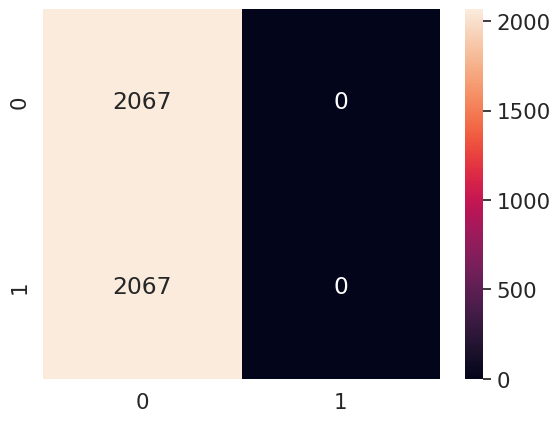

In [45]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

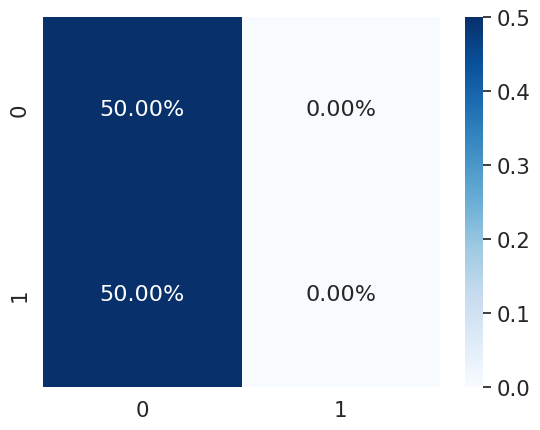

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues', annot_kws={"fontsize":16})
sns.set(font_scale=1.4)

# Save the image to a file
plt.savefig('CNN-LSTM-LSTM.pdf')
plt.show()

# Download the image file
from google.colab import files
files.download('CNN-LSTM-LSTM.pdf')

In [47]:
#CNN-GRU-GRU model

model = keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[64,64,3]), # Change input_shape to match the actual data shape
        keras.layers.Conv2D(filters=64, kernel_size=[7,7], strides=[1,1],
                            padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same",
                            activation="relu"),
         keras.layers.MaxPool2D(2),
        keras.layers.Reshape((16, 16*128)), #Explicitly calculate the reshape dimensions

        keras.layers.GRU(128, return_sequences=True),
        keras.layers.GRU(64, return_sequences=True),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(2, activation="softmax")
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_4           │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 16, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 16, 128)        │       836,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 16, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,022,670 (3.90 MB)

 Trainable params: 1,022,664 (3.90 MB)

 Non-trainable params: 6 (24.00 B)

In [48]:
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
model.fit(datagen.flow(X_tr, y_tr, batch_size=32), epochs=100, validation_data=(X_va, y_va),
          callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.0005, mode="min")])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.6879 - loss: 0.5612 - val_accuracy: 0.9429 - val_loss: 0.1956
Epoch 2/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step - accuracy: 0.9405 - loss: 0.1883 - val_accuracy: 0.9514 - val_loss: 0.1499
Epoch 3/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 68s 56ms/step - accuracy: 0.9454 - loss: 0.1657 - val_accuracy: 0.9584 - val_loss: 0.1370
Epoch 4/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.9542 - loss: 0.1407 - val_accuracy: 0.9577 - val_loss: 0.1220
Epoch 5/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.9537 - loss: 0.1345 - val_accuracy: 0.9541 - val_loss: 0.1272
Epoch 6/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.9529 - loss: 0.1350 - val_accuracy: 0.9611 - val_loss: 0.1142
Epoch 7/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.9576 - loss: 0.1270 - val_accuracy: 0.9589 - val_loss: 0.1257
Epoch 8/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.9595 - loss: 0

In [49]:
model.evaluate(X_te, y_te)

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9581 - loss: 0.1366


[0.13040472567081451, 0.9564586281776428]

In [50]:
y_pred= np.argmax(model.predict(X_te), axis=1)
y_pred

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


array([0, 1, 0, ..., 0, 1, 0])

In [51]:
y_pred
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te,y_pred)
cm

array([[1913,  154],
       [  26, 2041]])

In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2067
           1       0.93      0.99      0.96      2067

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134



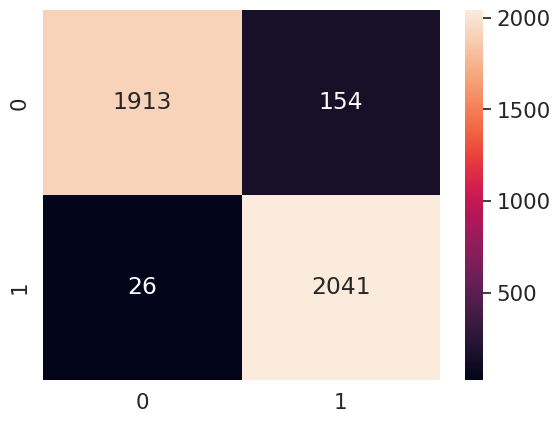

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

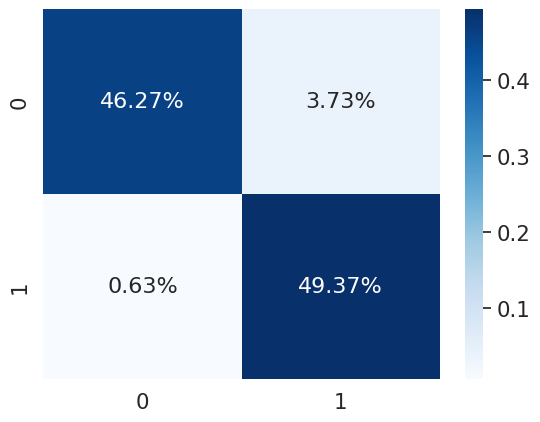

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues', annot_kws={"fontsize":16})
sns.set(font_scale=1.4)

# Save the image to a file
plt.savefig('CNN-GRU-GRU.pdf')
plt.show()

# Download the image file
from google.colab import files
files.download('CNN-GRU-GRU.pdf')

In [63]:
#CNN-BiLSTM-BiLSTM model

model = keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[64,64,3]),
        keras.layers.Conv2D(filters=64, kernel_size=[7,7], strides=[1,1],
                            padding="same", activation="relu"),
        keras.layers.MaxPool2D(pool_size=2),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same",
                            activation="relu"),
        keras.layers.MaxPool2D(2),

        keras.layers.Reshape((16*16, 128)),

        keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(2, activation="softmax")
])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_9           │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 256, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 256, 128)       │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,662 (889.30 KB)

 Trainable params: 227,656 (889.28 KB)

 Non-trainable params: 6 (24.00 B)

In [64]:
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
model.fit(datagen.flow(X_tr, y_tr, batch_size=32), epochs=100, validation_data=(X_va, y_va),
          callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.0005, mode="min")])

Epoch 1/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - accuracy: 0.5571 - loss: 0.6790 - val_accuracy: 0.6684 - val_loss: 0.6178
Epoch 2/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - accuracy: 0.6456 - loss: 0.6352 - val_accuracy: 0.5944 - val_loss: 0.6880
Epoch 3/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 45s 74ms/step - accuracy: 0.6657 - loss: 0.6131 - val_accuracy: 0.5507 - val_loss: 0.7052
Epoch 4/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 44s 72ms/step - accuracy: 0.6167 - loss: 0.6568 - val_accuracy: 0.5913 - val_loss: 0.6706
Epoch 5/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 82s 73ms/step - accuracy: 0.6221 - loss: 0.6523 - val_accuracy: 0.7067 - val_loss: 0.5732
Epoch 6/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - accuracy: 0.6507 - loss: 0.6259 - val_accuracy: 0.5001 - val_loss: 0.6924
Epoch 7/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - accuracy: 0.5805 - loss: 0.6532 - val_accuracy: 0.9047 - val_loss: 0.2681
Epoch 8/100
603/603 ━━━━━━━━━━━━━━━━━━━━ 47s 77ms/step - accuracy: 0.9173 - loss: 0

In [66]:
model.evaluate(X_te, y_te)

130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5058 - loss: 0.6929


[0.6930438280105591, 0.49854862689971924]

In [67]:
y_pred= np.argmax(model.predict(X_te), axis=1)
y_pred

130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step


array([0, 0, 0, ..., 0, 0, 0])

In [68]:
y_pred
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te,y_pred)
cm

array([[2060,    7],
       [2066,    1]])

In [69]:
from sklearn.metrics import classification_report

print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2067
           1       0.12      0.00      0.00      2067

    accuracy                           0.50      4134
   macro avg       0.31      0.50      0.33      4134
weighted avg       0.31      0.50      0.33      4134



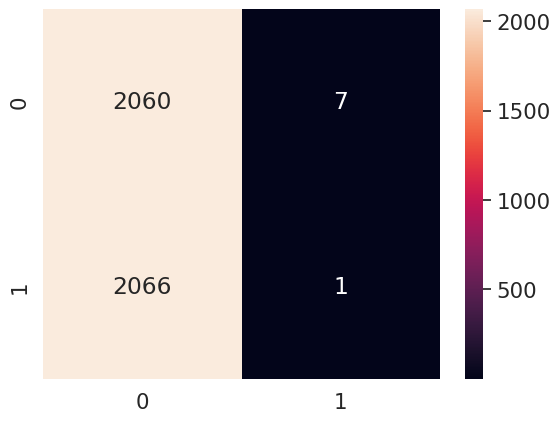

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

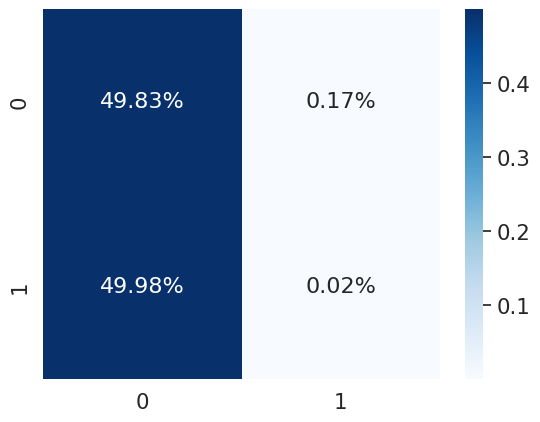

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues', annot_kws={"fontsize":16})
sns.set(font_scale=1.4)

# Save the image to a file
plt.savefig('CNN-BiLSTM-BiLSTM.pdf')
plt.show()

# Download the image file
from google.colab import files
files.download('CNN-BiLSTM-BiLSTM.pdf')